In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import itertools
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats import wilcoxon
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

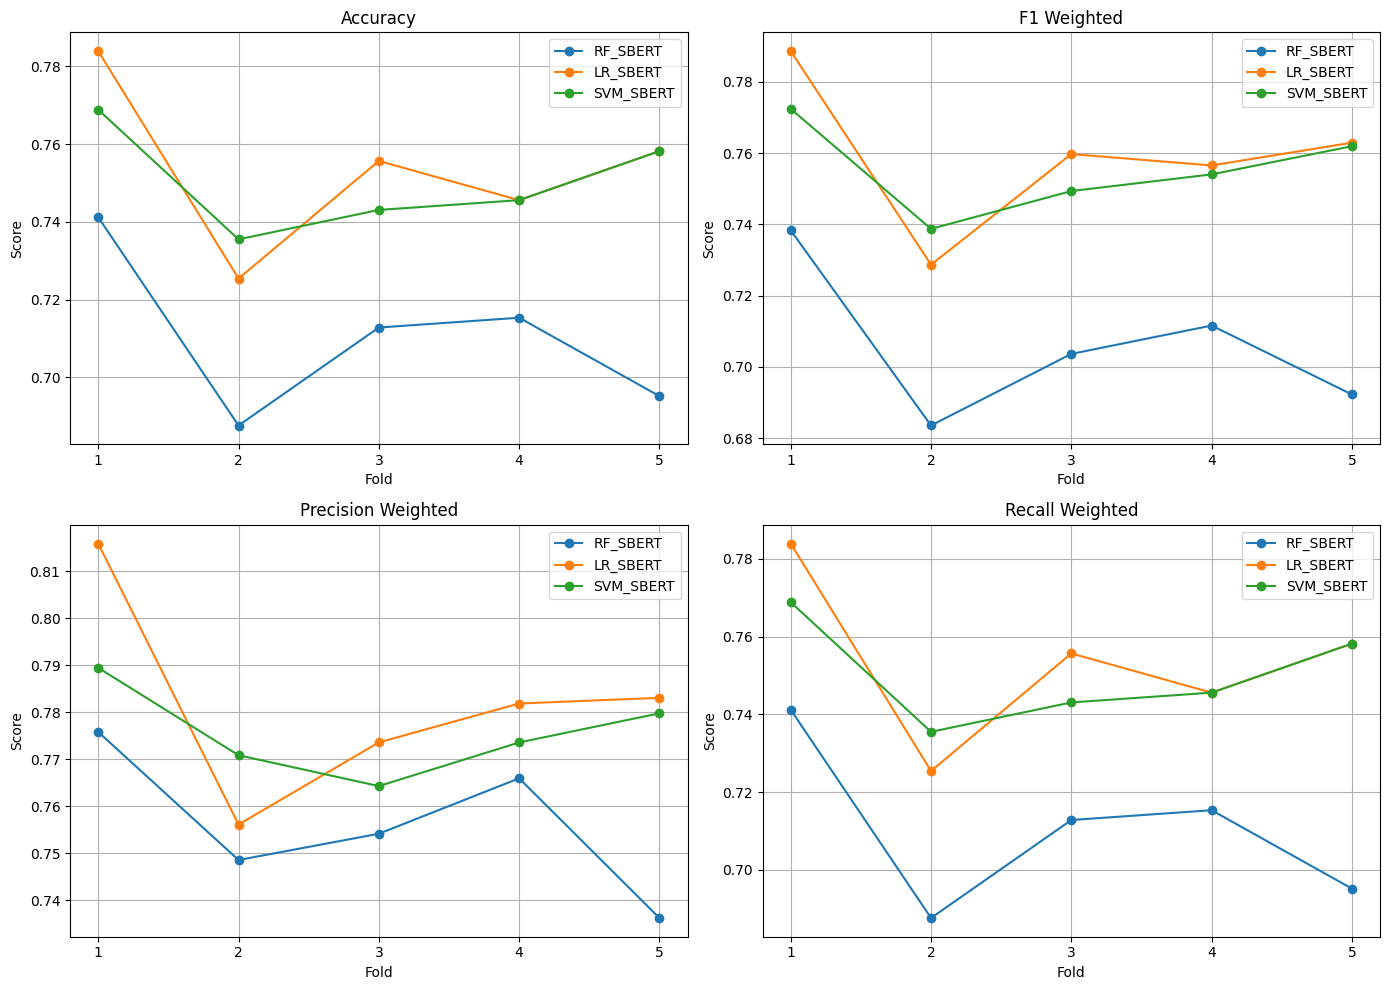

In [2]:
# Load model evaluation results from JSON file
with open('classifierEvaluation.json', 'r') as f:
    results = json.load(f)

# Extract test scores per metric for each model
model_metrics = {}
for model_key, model_data in results.items():
    model_metrics[model_key] = {}
    metrics = model_data['metrics']
    for metric_name, metric_data in metrics.items():
        # Get the list of scores for each fold in the test phase
        model_metrics[model_key][metric_name] = metric_data['test']['folds']

# List of metrics to visualize
metrics_list = ["accuracy", "f1_weighted", "precision_weighted", "recall_weighted"]

# === Line Plot per Fold ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_list):
    ax = axes[i]
    for model_key in model_metrics:
        scores = model_metrics[model_key][metric]
        ax.plot(
            range(1, len(scores) + 1),
            scores,
            marker='o',
            label=model_key
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('Fold')
    ax.set_ylabel('Score')
    ax.set_xticks(range(1, len(scores) + 1))
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

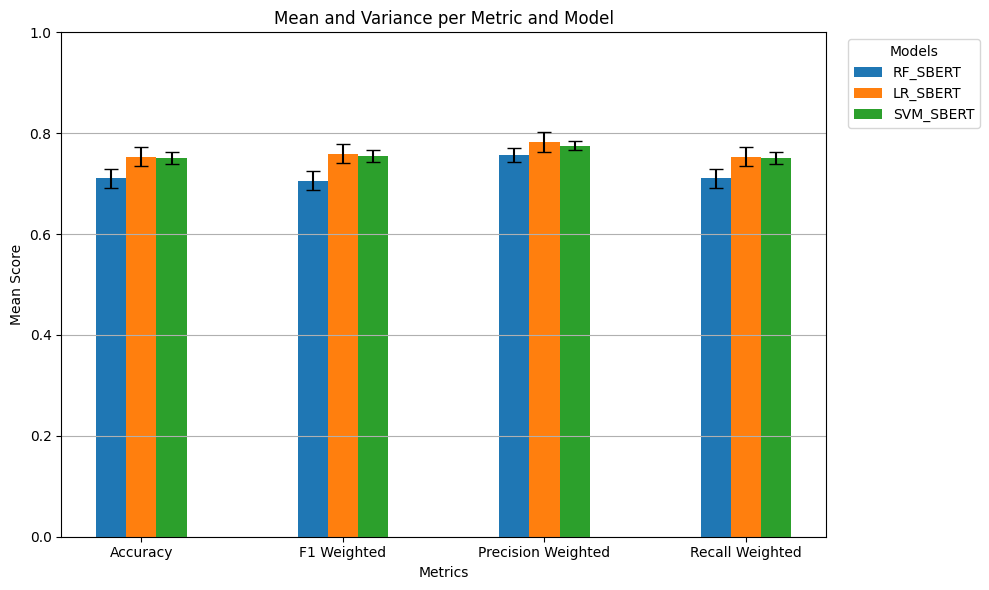

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean and standard deviation for each model and metric
model_names = list(model_metrics.keys())
num_models = len(model_names)
num_metrics = len(metrics_list)

metric_means = []
metric_stds = []

for metric in metrics_list:
    means = []
    stds = []
    for model in model_names:
        scores = model_metrics[model][metric]
        means.append(np.mean(scores))
        stds.append(np.std(scores))
    metric_means.append(means)
    metric_stds.append(stds)

# === Bar plot ===
x = np.arange(num_metrics)
width = 0.15
fig, ax = plt.subplots(figsize=(10, 6))  # Reduced width

# One bar per model within each metric group
for i, model in enumerate(model_names):
    means = [metric_means[j][i] for j in range(num_metrics)]
    stds = [metric_stds[j][i] for j in range(num_metrics)]
    offset = (i - num_models / 2) * width + width / 2
    ax.bar(
        x + offset,
        means,
        width,
        yerr=stds,
        label=model,
        capsize=5
    )

# Axis labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Score')
ax.set_title('Mean and Variance per Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_list])
ax.set_ylim(0, 1)  # Set Y-axis range
ax.grid(True, axis='y')

# Move legend to the right outside the plot
ax.legend(title='Models', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [4]:
# Extract f1_weighted scores for each model
f1_scores = {}
for model_key, metrics in model_metrics.items():
    if 'f1_weighted' in metrics:
        f1_scores[model_key] = metrics['f1_weighted']

# Pairwise comparison with Wilcoxon signed-rank test
model_names = list(f1_scores.keys())

print("Wilcoxon signed-rank test results on f1_weighted between models:\n")

for model1, model2 in itertools.combinations(model_names, 2):
    scores1 = f1_scores[model1]
    scores2 = f1_scores[model2]

    # Make sure both models have the same number of folds (required for paired test)
    if len(scores1) == len(scores2):
        stat, p = wilcoxon(scores1, scores2)
        print(f"{model1} vs {model2}: stat={stat:.4f}, p-value={p:.4f}")
        if p < 0.05:
            print("  -> Statistically significant difference (p < 0.05)\n")
        else:
            print("  -> No statistically significant difference\n")
    else:
        print(f"{model1} and {model2} have a different number of folds, test cannot be performed.\n")

Wilcoxon signed-rank test results on f1_weighted between models:

RF_SBERT vs LR_SBERT: stat=0.0000, p-value=0.0625
  -> No statistically significant difference

RF_SBERT vs SVM_SBERT: stat=0.0000, p-value=0.0625
  -> No statistically significant difference

LR_SBERT vs SVM_SBERT: stat=3.0000, p-value=0.3125
  -> No statistically significant difference



In [5]:
# Extract roc_auc_ovr_weighted scores for each model
auc_scores = {}
for model_key, metrics in model_metrics.items():
    if 'roc_auc_ovr_weighted' in metrics:
        auc_scores[model_key] = metrics['roc_auc_ovr_weighted']

# Pairwise comparison with Wilcoxon signed-rank test
model_names = list(auc_scores.keys())

print("Wilcoxon signed-rank test results on roc_auc_ovr_weighted between models:\n")

for model1, model2 in itertools.combinations(model_names, 2):
    scores1 = auc_scores[model1]
    scores2 = auc_scores[model2]

    # Make sure both models have the same number of folds (important for paired test)
    if len(scores1) == len(scores2):
        stat, p = wilcoxon(scores1, scores2)
        print(f"{model1} vs {model2}: stat={stat:.4f}, p-value={p:.4f}")
        if p < 0.05:
            print("  -> Statistically significant difference (p < 0.05)\n")
        else:
            print("  -> No statistically significant difference\n")
    else:
        print(f"{model1} and {model2} have a different number of folds, test cannot be performed.\n")

Wilcoxon signed-rank test results on roc_auc_ovr_weighted between models:

RF_SBERT vs LR_SBERT: stat=0.0000, p-value=0.0625
  -> No statistically significant difference

RF_SBERT vs SVM_SBERT: stat=0.0000, p-value=0.0625
  -> No statistically significant difference

LR_SBERT vs SVM_SBERT: stat=2.0000, p-value=0.1875
  -> No statistically significant difference



In [6]:
train_path = "PreProcessingResumes/processed_data/Resume/train.csv"  
test_path = "PreProcessingResumes/processed_data/Resume/test.csv"    

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [7]:
encoder = LabelEncoder()
encoder.fit(train_df['Category'])

X_train = train_df['Resume_str'].tolist()
y_train = encoder.transform(train_df['Category'])

X_test = test_df['Resume_str'].tolist()
y_test = encoder.transform(test_df['Category'])

In [8]:
# Load the SBERT model for generating sentence embeddings
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [9]:
# Generate SBERT embeddings
X_train_embed = sbert_model.encode(X_train, show_progress_bar=True)
X_test_embed = sbert_model.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
class_counts = train_df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())

min_classes_encoded = encoder.transform(min_classes)
sampling_strategy = {label: target_size for label in min_classes_encoded}

Applying SMOTE to classes: ['ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [11]:
def get_model_class(key_name):
    if key_name.startswith("RF"):
        return RandomForestClassifier
    elif key_name.startswith("LR"):
        return LogisticRegression
    elif key_name.startswith("SVM"):
        return SVC
    else:
        raise ValueError(f"Unknown model prefix in key: {key_name}")

selected_model_key = "SVM_SBERT"

config = results[selected_model_key]
raw_params = config["params"]
model_params = {k.replace("clf__", ""): v for k, v in raw_params.items()}
if selected_model_key.startswith("SVM"):
    model_params["probability"] = True

ModelClass = get_model_class(selected_model_key)

model = ModelClass(**model_params)

In [12]:
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', model)
])

In [13]:
pipeline.fit(X_train_embed, y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=4, random_state=42,
                       sampling_strategy={1: 103, 2: 103, 3: 103, 4: 103,
                                          5: 103, 8: 103})),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

In [14]:
y_train_pred = pipeline.predict(X_train_embed)
y_test_pred = pipeline.predict(X_test_embed)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

Train Accuracy: 0.8646
Test Accuracy: 0.7586


In [15]:
print(classification_report(y_test, y_test_pred, target_names=encoder.classes_, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.90      0.93      0.91        28
              ADVOCATE       0.56      0.69      0.62        13
           AGRICULTURE       1.00      0.50      0.67         6
               APPAREL       0.44      0.64      0.52        11
                  ARTS       1.00      0.40      0.57         5
            AUTOMOBILE       0.00      0.00      0.00         2
              AVIATION       0.65      0.79      0.71        19
               BANKING       0.78      0.41      0.54        17
                   BPO       0.30      0.60      0.40        10
  BUSINESS-DEVELOPMENT       0.73      0.69      0.71        35
                  CHEF       0.90      0.95      0.93        20
          CONSTRUCTION       0.95      0.86      0.90        22
            CONSULTANT       0.73      0.79      0.76        24
              DESIGNER       0.86      0.86      0.86        22
         DIGITAL-MEDIA       0.65      

<Figure size 1500x1000 with 0 Axes>

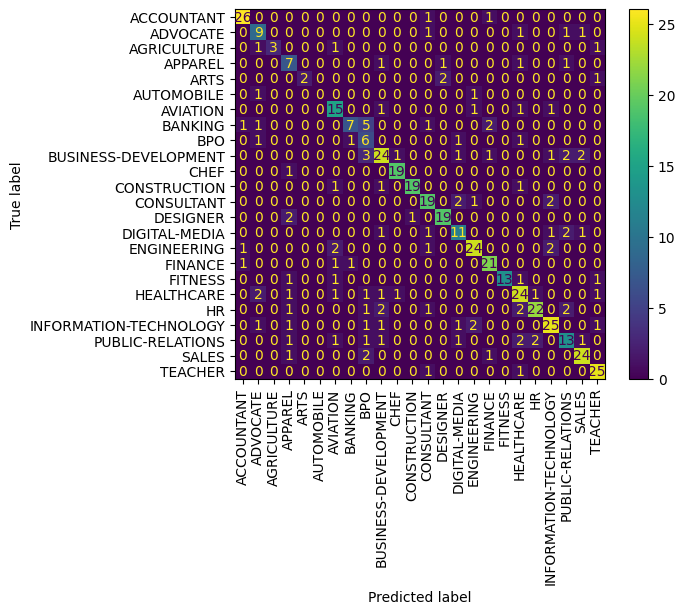

In [16]:
# Confusion Matrix
plt.figure(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=encoder.classes_)
plt.xticks(rotation=90)
plt.show()

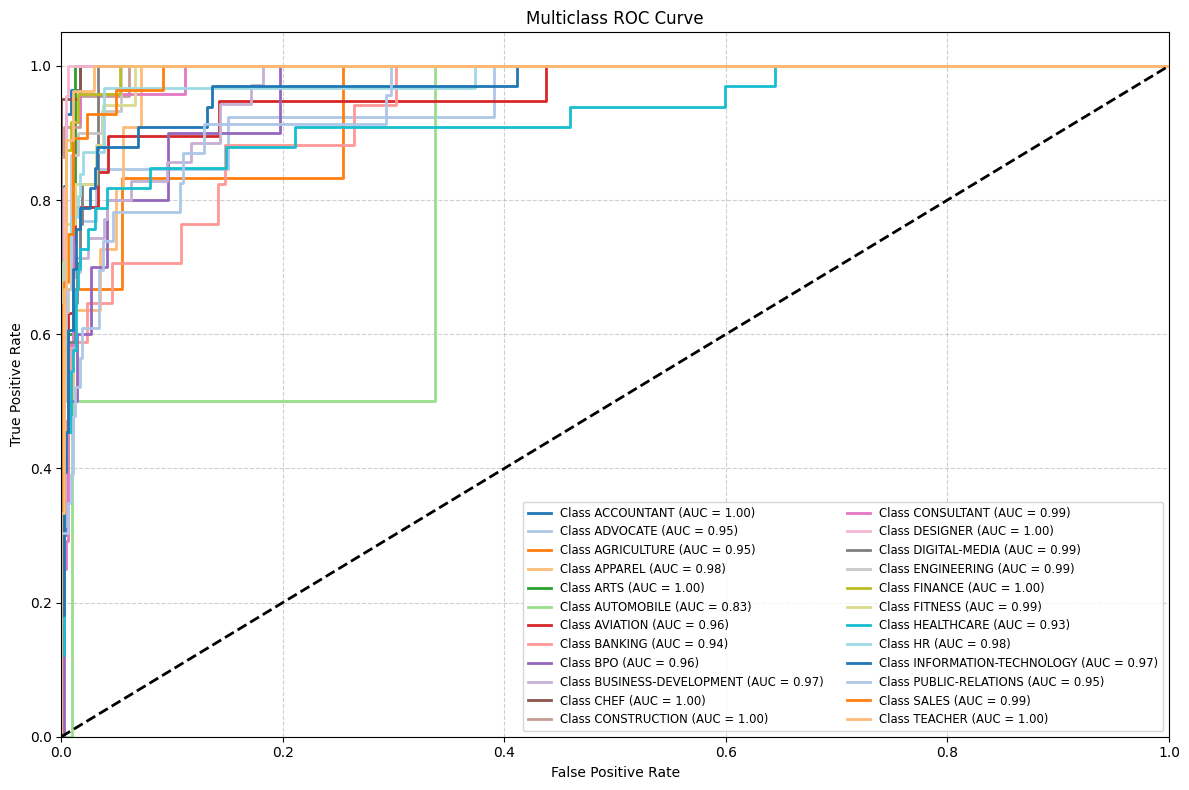

In [17]:
# Binarize test labels for one-vs-rest ROC computation
y_test_bin = label_binarize(y_test, classes=range(len(encoder.classes_)))
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for each class
y_score = pipeline.predict_proba(X_test_embed)

# Compute ROC curve and AUC for each class
fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # Area Under the Curve

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Set color palette
colors = cycle(plt.cm.tab20.colors)

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Diagonal line representing random guess
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
# Save the trained pipeline (SMOTE + classifier) for web app use
joblib.dump(pipeline, 'Models/sbert_svm_pipeline.joblib')

# Save the label encoder for inverse transformation in the web app
joblib.dump(encoder, 'Models/label_encoder.joblib')

print("Models saved")

Models saved
